# Sentiment Analysis Using Tensorflow LSTM - CNN with Attention Layer

## Imports

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, Conv1D, MaxPooling1D, Embedding, Dropout,Dense, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import RMSprop, Adamax , Adam

from attention.layers import AttentionLayer
import tensorflow as tf
from tensorflow.python.client import device_lib

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #This is for multiple print statements per cell

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Confirm GPU processing available

In [2]:
value = tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
print ('***If TF can access GPU: ***\n\n',value) # MUST RETURN True IF IT CAN!!

print()
value = tf.config.list_physical_devices('GPU')
print(value)

print()
print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
***If TF can access GPU: ***

 True

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17144774613523864823
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10899328592941501521
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5054066414803236687
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1259942707
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1038032525735692042
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


## Getting data

In [3]:
df = pd.read_csv('consolidated_tweet_data-cleaned-stemmed-lemmatized.csv', sep='\t')
df

,sentiment,text
0,negative,oh no it fade away again
1,positive,bunnylak will kill me but i cant stop listen t...
2,negative,last day in cali partyin for the last time wit...
3,negative,is have a major soar throat
4,positive,my last day a 12 year old
...,...,...
1611536,negative,twisuz yeah and how did thi happen i wa updat ...
1611537,negative,smittygoali im sorri about your dog
1611538,negative,posipat im alreadi there i wish you were here
1611539,negative,is think in 12 hour ill be at the airport thi ...


In [4]:
# How much of Dataset to be used
frac = 0.25
# sample and shuffle the dataset according to the fraction choise in the line above
df = df.sample(frac=frac).reset_index(drop=True)
df

,sentiment,text
0,negative,well cleveland did not have a good night
1,positive,btw good morn and have a great day everyon oh ...
2,positive,staceykay doyourememberwhen you had to get up ...
3,negative,on my way to heather for grad partyhop to see ...
4,negative,my mouth tast like poor choic
...,...,...
402880,negative,i realli hope she isnt date him
402881,negative,odarygh nodnod it realli boggl my mind a rydra...
402882,negative,mahika oh lol yeah sam is not ahead
402883,negative,at work till eleven


## Tokenization for training

In [5]:
vocabulary_size = 8000

In [6]:
tokenizer = Tokenizer(num_words=vocabulary_size, split=" ", oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'].values)

In [7]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   71, 3481,
         126,   27,   17,    5,   32,   73],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  507,   32,  100,    8,   17,    5,  104,
          29,  174,   90,  148,    8,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    1,    1,
           9,   68,    3,   26,   33,    8,  381,    4, 5959,   16,    4,
         420,    3,   26,  295,  580, 1122],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   16,
           7,  132,    3, 3767,   11, 1447,    1,  

## Model, Training and Testing

### Creating the model

In [8]:
model = Sequential()
model.add(Embedding(vocabulary_size, 256, input_length=X.shape[1]))
# model.add(Dropout(0.3))
model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Conv1D(32,16,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64,12,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128,9,padding="same",activation="relu"))
model.add(MaxPooling1D(pool_size=2))
model.add(AttentionLayer(name='attention'))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid'))

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 256)           2048000   
_________________________________________________________________
bidirectional (Bidirectional (None, 39, 512)           1052672   
_________________________________________________________________
dropout (Dropout)            (None, 39, 512)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            262176    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 19, 64)            24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 64)             0

### Training the model

In [12]:
y = pd.get_dummies(df['sentiment']).values
[print(df['sentiment'][i], y[i]) for i in range(0,5)]

negative [1 0]
positive [0 1]
positive [0 1]
negative [1 0]
negative [1 0]


[None, None, None, None, None]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
batch_size = 32
epochs = 6
import time
from datetime import datetime
datetime = str(datetime.now())
csv_logger = tf.keras.callbacks.CSVLogger('training'+datetime+'.log')
start = time.time()
print("started at:")
print(start)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, callbacks=[csv_logger])
end = time.time()
elapsed = end - start
print(elapsed/60," minutes")

started at:
1586177840.9282196
Train on 322308 samples
Epoch 1/6
322308/322308 - 452s - loss: 0.4570 - accuracy: 0.7855
Epoch 2/6
322308/322308 - 442s - loss: 0.4076 - accuracy: 0.8154
Epoch 3/6
322308/322308 - 437s - loss: 0.3812 - accuracy: 0.8309
Epoch 4/6
322308/322308 - 436s - loss: 0.3541 - accuracy: 0.8457
Epoch 5/6
322308/322308 - 440s - loss: 0.3250 - accuracy: 0.8601
Epoch 6/6
322308/322308 - 441s - loss: 0.2926 - accuracy: 0.8769
44.14477658669154  minutes


Plotting training history

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

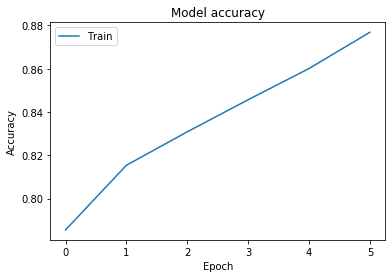

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

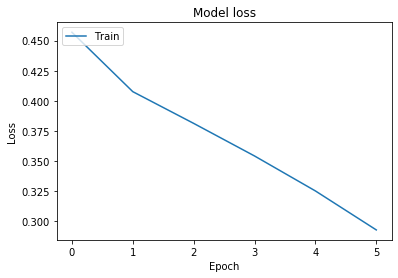

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Testing the model

In [16]:
predictions = model.predict(X_test)
[print(df['text'][i], predictions[i], y_test[i]) for i in range(0, 5)]

well cleveland did not have a good night  [0.9767314  0.02302214] [1 0]
btw good morn and have a great day everyon oh yeah and firepratt  [0.94851834 0.05099851] [1 0]
staceykay doyourememberwhen you had to get up and turn the dial on the tv to get those 7 channel  [0.8787651  0.12203421] [1 0]
on my way to heather for grad partyhop to see erikscottberg there havent realli seen him sinc thur  [0.96657526 0.03268743] [1 0]
my mouth tast like poor choic  [0.0375951 0.9619317] [1 0]


[None, None, None, None, None]

In [17]:
accurate_prediction_count, inaccurate_prediction_count = 0, 0
for i, prediction in enumerate(predictions):
    if np.argmax(prediction)==np.argmax(y_test[i]):
        accurate_prediction_count += 1
    else:
        inaccurate_prediction_count += 1

total_predictions = accurate_prediction_count + inaccurate_prediction_count
print('Number of predictions: ', total_predictions)
print('Number of accurate predictions: ', accurate_prediction_count)
print('Number of false predictions: ', inaccurate_prediction_count)    
print('Accuracy: ', accurate_prediction_count/total_predictions)

Number of predictions:  80577
Number of accurate predictions:  64739
Number of false predictions:  15838
Accuracy:  0.803442669744468


### Saving the trained model

name of the file

In [18]:
name = 'sentiment-analysis-trained-model'

In [19]:
from datetime import datetime
dateTimeObj = datetime.now()
date = str(dateTimeObj.date())
time = str(dateTimeObj.time())
timestamp = date+time
punctuation = ['-',':','.']
for sign in punctuation:
    timestamp = timestamp.replace(sign,'')
print(timestamp)

20200406164518139874


In [20]:
model.save(name+timestamp+'.h5')